<h1 style="text-align: center; color: black;" markdown="1">QTM 347 Machine Learning: Project </h1>
<h2 style="text-align: center; color: black;" markdown="1">Marco Ren </h2>

First of all, we import the libraries.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import itertools
import time
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from ISLP.models import sklearn_sm
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor as RF
import sklearn.linear_model as skl
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_validate, cross_val_score
from sklearn.model_selection import train_test_split
import sklearn.model_selection as skm
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

We then load and clean the datasets.

In [2]:
df = pd.read_csv("weatherAUS.csv")

df_Perth = df[df['Location'] == 'Perth'].reset_index(drop=True)
df_Perth['Date'] = pd.to_datetime(df_Perth['Date'])
df_Perth['Month'] = df_Perth['Date'].dt.month
df_Perth['Humidity'] = df_Perth[['Humidity9am', 'Humidity3pm']].mean(axis=1)
df_Perth['Pressure'] = df_Perth[['Pressure9am', 'Pressure3pm']].mean(axis=1)
df_Perth['Cloud'] = df_Perth[['Cloud9am', 'Cloud3pm']].mean(axis=1)

dummies = pd.get_dummies(df_Perth[['RainToday', 'RainTomorrow']])
df_Perth = pd.concat([df_Perth, dummies], axis=1)
df_Perth[dummies.columns] = df_Perth[dummies.columns].astype(int)

df_Perth = df_Perth.drop(['Date', 'Location', 'WindGustDir', 'WindDir9am', 
                          'WindDir3pm', 'Humidity9am', 'Humidity3pm', 
                          'Pressure9am', 'Pressure3pm', 'Cloud9am', 
                          'Cloud3pm', 'WindSpeed9am', 'WindSpeed3pm', 
                          'Temp9am', 'Temp3pm', 'RainToday', 'RainToday_No', 
                          'RainTomorrow', 'RainTomorrow_No'], axis=1)
df_Perth.dropna(inplace=True)
print(df_Perth.head())

   MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  WindGustSpeed  Month  \
0      2.7     18.8       0.0          0.8       9.1           20.0      7   
1      6.4     20.7       0.0          1.8       7.0           22.0      7   
2      6.5     19.9       0.4          2.2       7.3           31.0      7   
3      9.5     19.2       1.8          1.2       4.7           26.0      7   
4      9.5     16.4       1.8          1.4       4.9           44.0      7   

   Humidity  Pressure  Cloud  RainToday_Yes  RainTomorrow_Yes  
0      75.0   1026.05    2.5              0                 0  
1      59.5   1021.55    3.0              0                 0  
2      77.5   1016.20    2.0              0                 1  
3      83.0   1018.85    6.0              1                 1  
4      63.0   1021.25    6.0              1                 1  


## Data Exploration

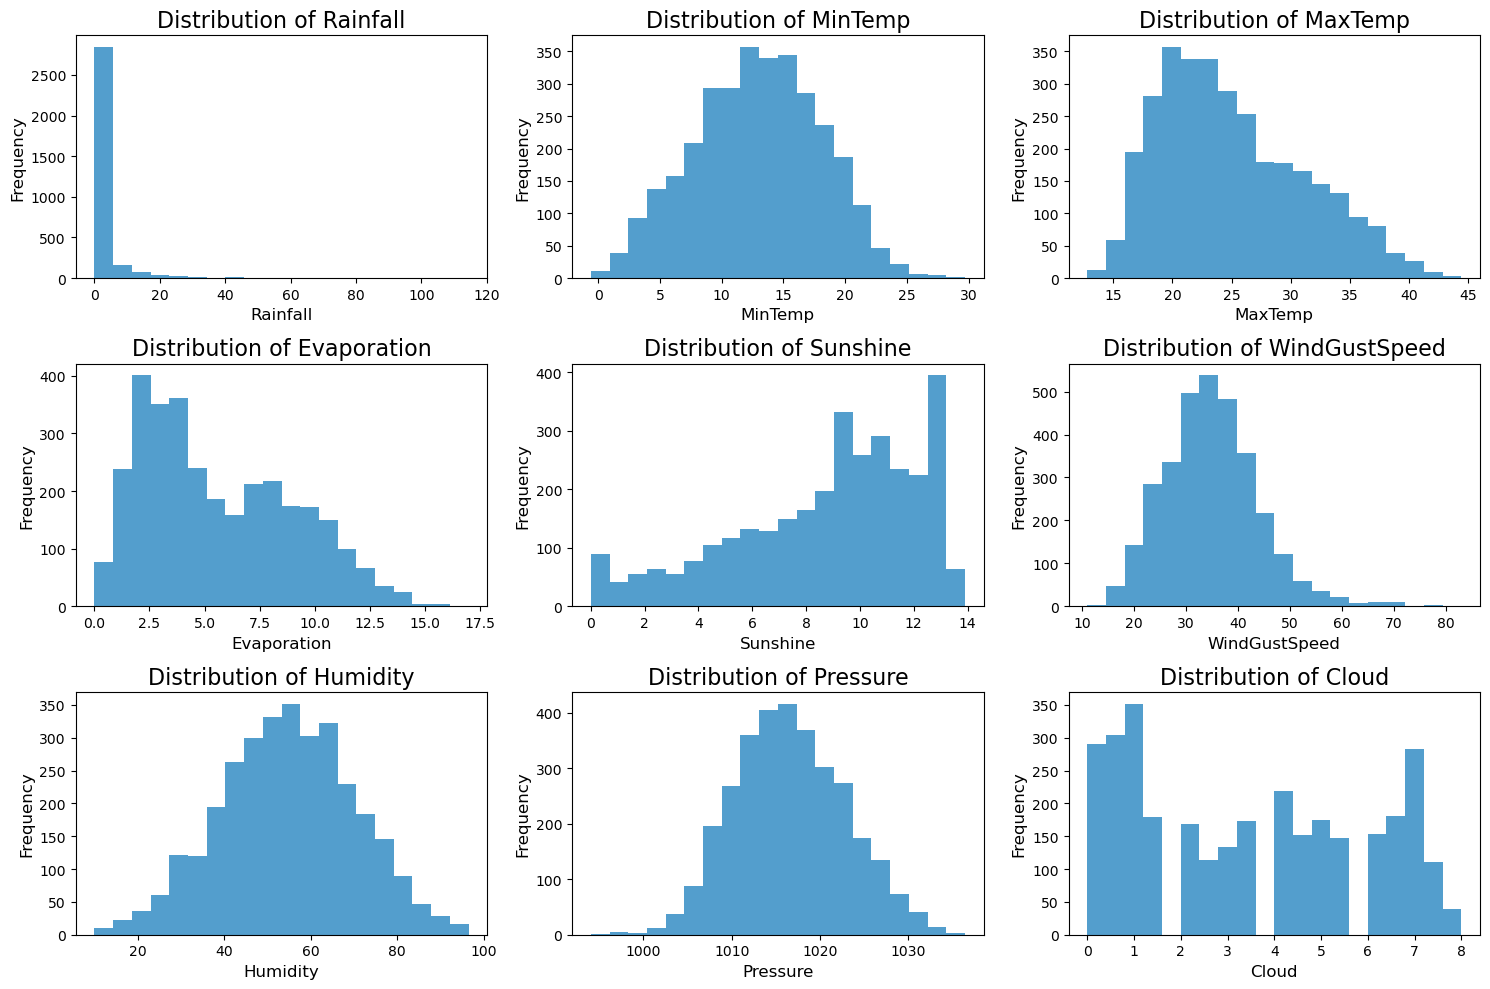

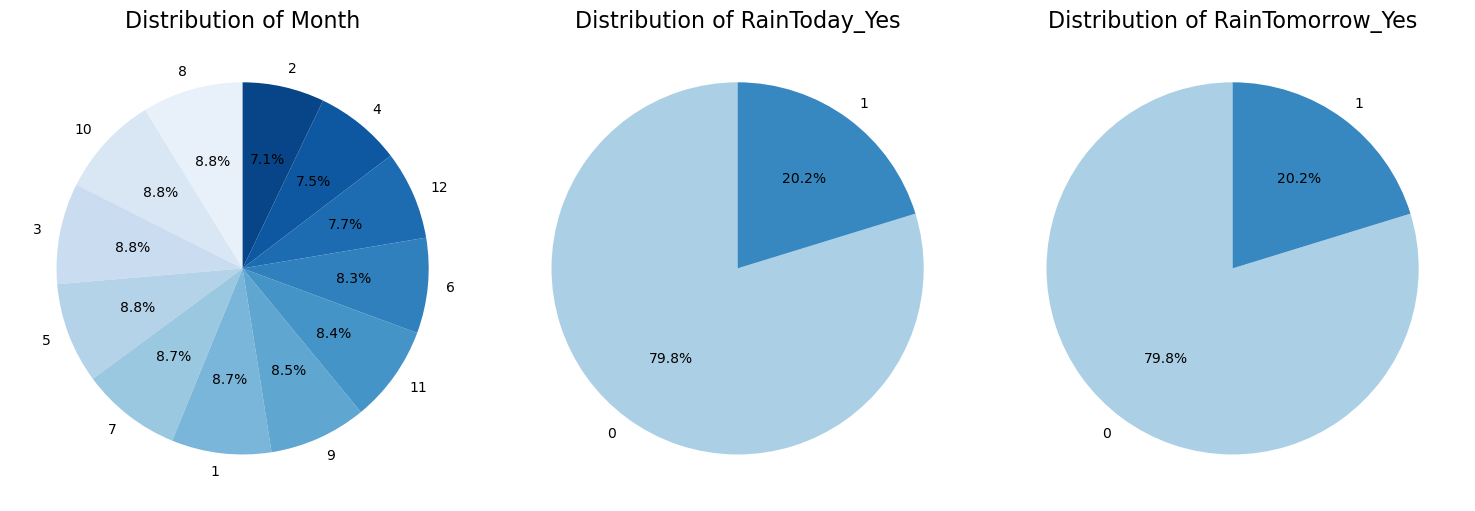

In [3]:
numerical_vars = ['Rainfall', 'MinTemp', 'MaxTemp', 'Evaporation', 'Sunshine', 
                  'WindGustSpeed', 'Humidity', 'Pressure', 'Cloud']
categorical_vars = ['Month', 'RainToday_Yes', 'RainTomorrow_Yes']

fig, axes = plt.subplots(3, 3, figsize=(15, 10))
axes = axes.flatten()

for i, var in enumerate(numerical_vars):
    ax = axes[i]
    ax.hist(df_Perth[var], bins=20, color=sns.color_palette("Blues")[3])
    ax.set_title(f'Distribution of {var}', fontsize=16)
    ax.set_xlabel(var, fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    
plt.tight_layout()

fig_cat, axes_cat = plt.subplots(1, len(categorical_vars), figsize=(15, 5))
axes_cat = axes_cat.flatten()

for i, var in enumerate(categorical_vars):
    ax = axes_cat[i]
    category_counts = df_Perth[var].value_counts()
    category_counts.plot(kind='pie', autopct='%1.1f%%', 
                         colors=sns.color_palette('Blues', len(category_counts)),
                         startangle=90, legend=False, ax=ax)
    ax.set_title(f'Distribution of {var}', fontsize=16)
    ax.set_ylabel('')

plt.tight_layout()
plt.show()

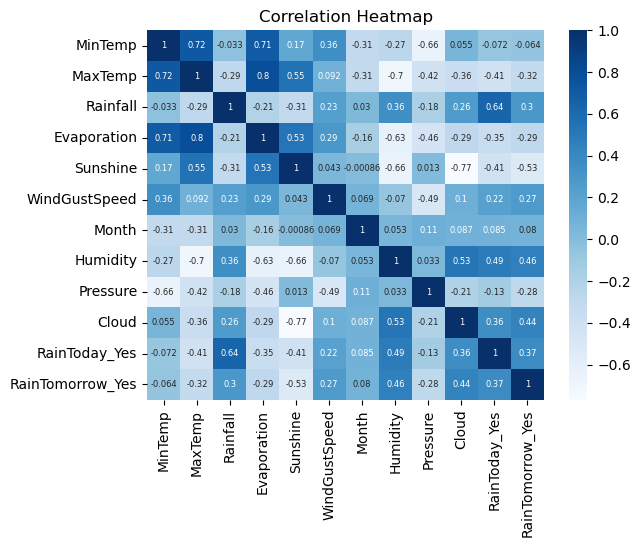

In [4]:
corr_matrix = df_Perth.corr()
sns.heatmap(corr_matrix, cmap='Blues', annot = True,  annot_kws={"size": 6})
plt.title("Correlation Heatmap")

plt.show()

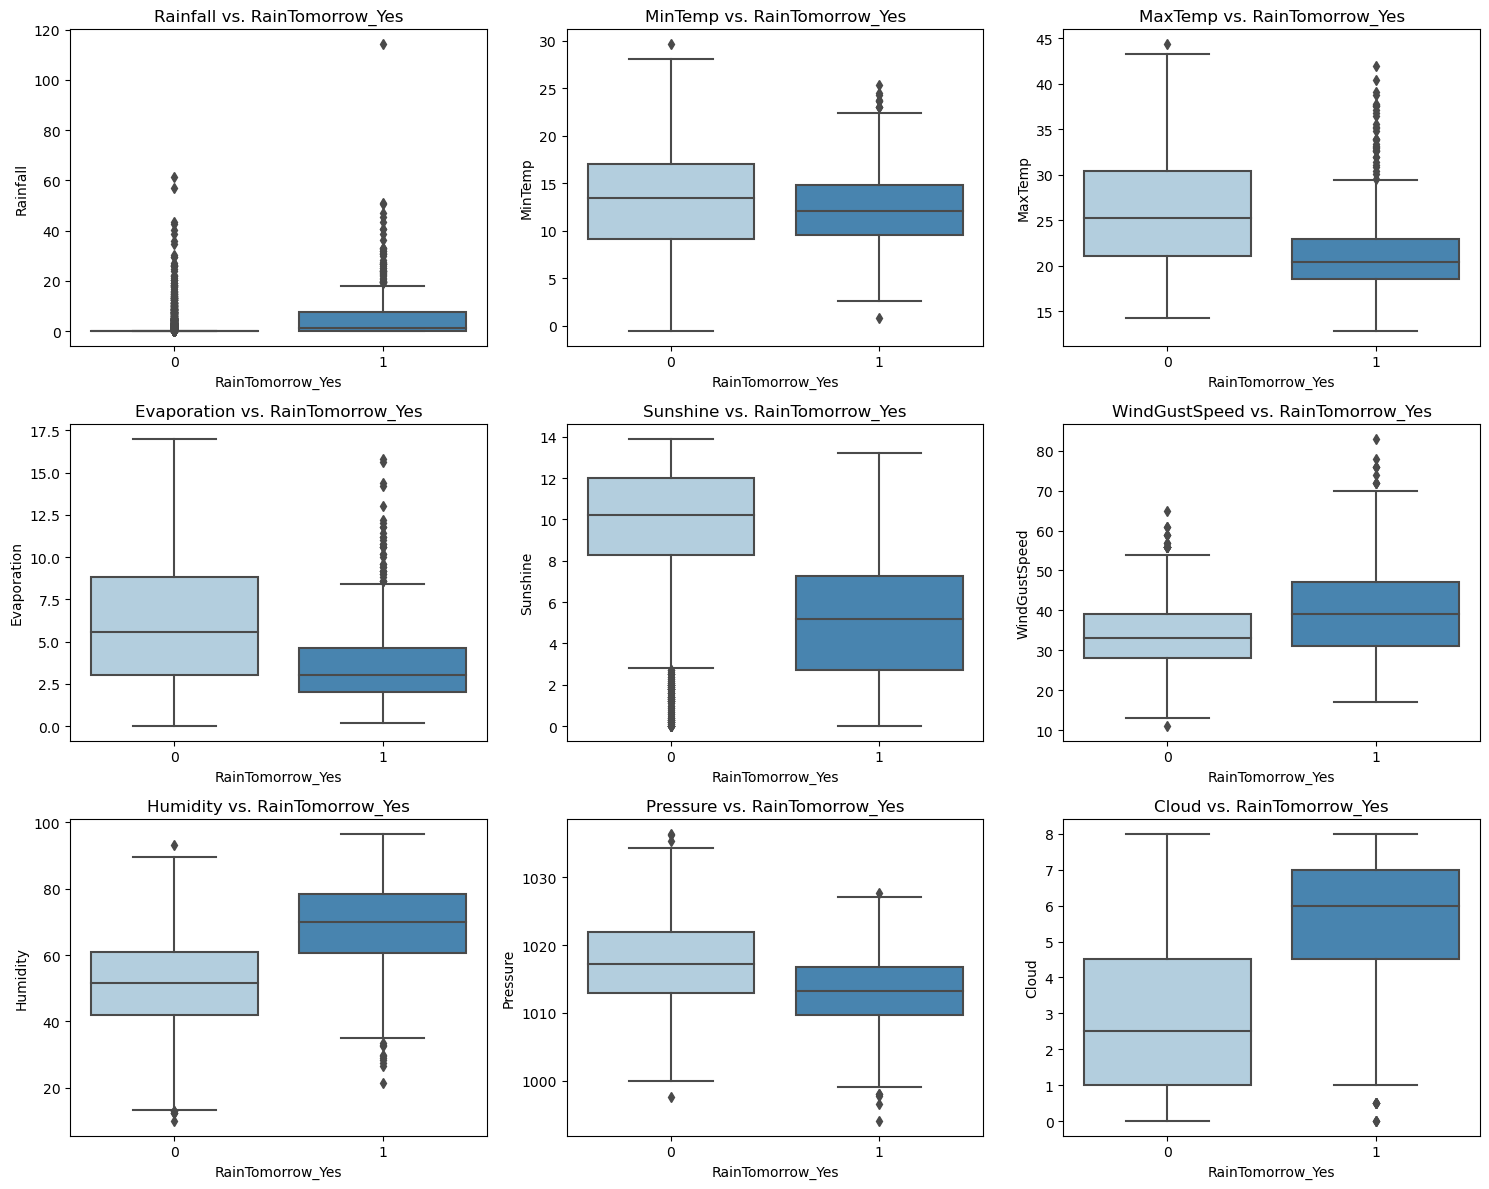

In [5]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for i, var in enumerate(numerical_vars):
    ax = axes[i]
    sns.boxplot(x='RainTomorrow_Yes', y=var, data=df_Perth, ax=ax, palette='Blues')
    ax.set_title(f'{var} vs. RainTomorrow_Yes')
        
plt.tight_layout()
plt.show()

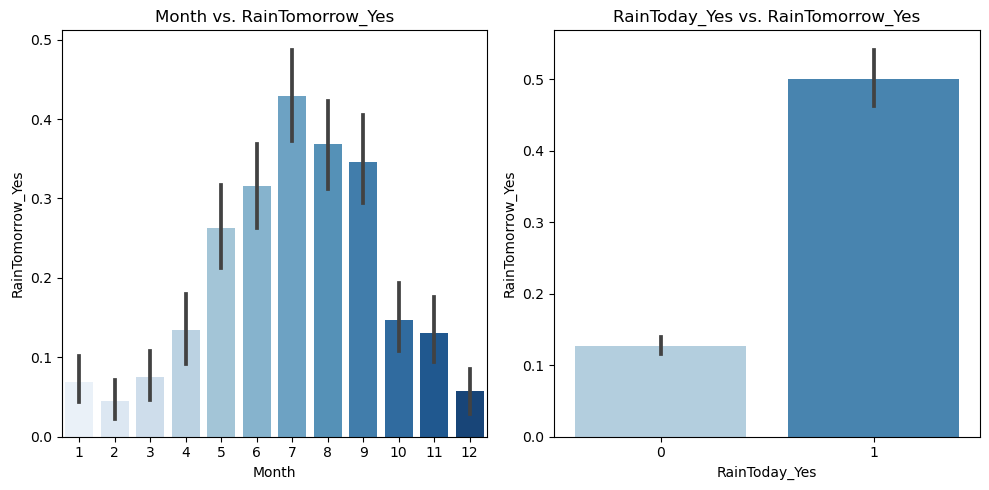

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes = axes.flatten()

for i, var in enumerate(categorical_vars[0:2]):
    ax = axes[i]
    sns.barplot(x=var, y='RainTomorrow_Yes', data=df_Perth, ax=ax,  palette='Blues')
    ax.set_title(f'{var} vs. RainTomorrow_Yes')

plt.tight_layout()
plt.show()

## Parametric Model

#### Logistic Model

In [7]:
X = df_Perth.drop(['RainTomorrow_Yes'], axis=1).astype('float64')
y = df_Perth['RainTomorrow_Yes']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=0)
misclassification_error_parametric = []

In [8]:
X_train_con = sm.add_constant(X_train)
X_test_con = sm.add_constant(X_test)

model = sm.Logit(y_train, X_train_con)
logistic_model = model.fit(disp=False)
print(logistic_model.summary())

                           Logit Regression Results                           
Dep. Variable:       RainTomorrow_Yes   No. Observations:                 2540
Model:                          Logit   Df Residuals:                     2528
Method:                           MLE   Df Model:                           11
Date:                Fri, 06 Dec 2024   Pseudo R-squ.:                  0.5083
Time:                        00:40:10   Log-Likelihood:                -626.98
converged:                       True   LL-Null:                       -1275.2
Covariance Type:            nonrobust   LLR p-value:                2.696e-271
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           254.2976     21.291     11.944      0.000     212.568     296.027
MinTemp          -0.2553      0.033     -7.746      0.000      -0.320      -0.191
MaxTemp           0.0978      0.033     

In [9]:
y_pred = logistic_model.predict(X_test_con)

y_pred_binary = (y_pred >= 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred_binary)
error_rate = 1 - accuracy
misclassification_error_parametric.append(error_rate)

print(f"Misclassification Error Rate: {error_rate:.4f}")

Misclassification Error Rate: 0.1226


#### Forward Selection

In [10]:
def processSubset(feature_set):
    if feature_set.count('const') == 0:
        feature_set_list = list(feature_set)
        feature_set_list.append('const')
        feature_set = tuple(feature_set_list)
        
    X = X_train_con[list(feature_set)]
    X = sm.add_constant(X, has_constant='add')
    model = sm.Logit(y_train, X_train_con[list(feature_set)])
    regr = model.fit(disp=False)
    log_likelihood = regr.llf
    return {"model":regr, "Log-likelihood":log_likelihood}

In [11]:
def forward(predictors):

    remaining_predictors = [p for p in X.columns if p not in predictors]
    
    tic = time.time()
    
    results = []
    
    for p in remaining_predictors:
        model_predictors = tuple(predictors + [p])
        results.append(processSubset(model_predictors))
    
    models = pd.DataFrame(results)
    
    best_model = models.loc[models['Log-likelihood'].argmax()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, 
          "predictors in", (toc-tic), "seconds.")
    
    return best_model

In [12]:
models_fwd = pd.DataFrame(columns=["Log-likelihood", "model"])

tic = time.time()
predictors = []

for i in range(1,len(X.columns)+1):
    models_fwd.loc[i] = forward(predictors)
    predictors = models_fwd.loc[i]["model"].model.exog_names

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed  11 models on 1 predictors in 0.083740234375 seconds.
Processed  10 models on 3 predictors in 0.06796932220458984 seconds.
Processed  9 models on 4 predictors in 0.056418418884277344 seconds.
Processed  8 models on 5 predictors in 0.06377434730529785 seconds.
Processed  7 models on 6 predictors in 0.08692073822021484 seconds.
Processed  6 models on 7 predictors in 0.06696510314941406 seconds.
Processed  5 models on 8 predictors in 0.04996156692504883 seconds.
Processed  4 models on 9 predictors in 0.031102657318115234 seconds.
Processed  3 models on 10 predictors in 0.04684877395629883 seconds.
Processed  2 models on 11 predictors in 0.032492876052856445 seconds.
Processed  1 models on 12 predictors in 0.020605802536010742 seconds.
Total elapsed time: 0.6168265342712402 seconds.


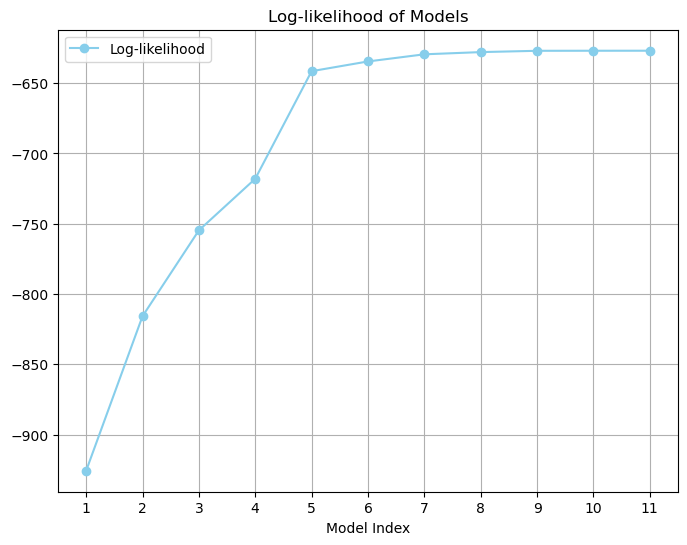

In [13]:
log_likelihood_values = []

for i in range(1, 12):
    log_likelihood_value = models_fwd.loc[i, 'Log-likelihood']
    log_likelihood_values.append(log_likelihood_value)  

plt.figure(figsize=(8, 6))
plt.plot(list(range(1, 12)), log_likelihood_values, marker='o', linestyle='-', 
         color='skyblue', label='Log-likelihood')
plt.title('Log-likelihood of Models')
plt.xlabel('Model Index')
plt.xticks(range(1, 12))

plt.legend()
plt.grid(True)
plt.show()

In [14]:
best_model_fwd = models_fwd.loc[7, 'model']
print(best_model_fwd.summary())

                           Logit Regression Results                           
Dep. Variable:       RainTomorrow_Yes   No. Observations:                 2540
Model:                          Logit   Df Residuals:                     2532
Method:                           MLE   Df Model:                            7
Date:                Fri, 06 Dec 2024   Pseudo R-squ.:                  0.5063
Time:                        00:40:11   Log-Likelihood:                -629.53
converged:                       True   LL-Null:                       -1275.2
Covariance Type:            nonrobust   LLR p-value:                1.282e-274
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Sunshine         -0.3557      0.028    -12.482      0.000      -0.412      -0.300
const           251.7128     20.607     12.215      0.000     211.323     292.102
WindGustSpeed     0.0855      0.009     

In [15]:
y_pred = best_model_fwd.predict(X_test_con[list(best_model_fwd.model.exog_names)])

y_pred_binary = (y_pred >= 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred_binary)
error_rate = 1 - accuracy
misclassification_error_parametric.append(error_rate)

print(f"Misclassification Error Rate: {error_rate:.4f}")

Misclassification Error Rate: 0.1164


#### Ridge

In [19]:
K = 5
kfold = skm.KFold(K, random_state=0, shuffle=True)

pipe_logistic_ridge = make_pipeline(StandardScaler(), 
                                    LogisticRegression(solver='lbfgs', 
                                                       max_iter=500))

lambdas = 10**np.linspace(10, -10, 100) / y_train.std()

param_grid_ridge = {
    'logisticregression__penalty': ['l2'],
    'logisticregression__C': 1 / lambdas,
}

grid_search_logistic_ridge = GridSearchCV(pipe_logistic_ridge, 
                                          param_grid_ridge, 
                                          cv=kfold, 
                                          scoring='accuracy')

grid_search_logistic_ridge.fit(X_train, y_train)

best_alpha_ridge = list(grid_search_logistic_ridge.best_params_.values())[0]
print(f"alpha = {best_alpha_ridge}")

alpha = 0.1995597548730963


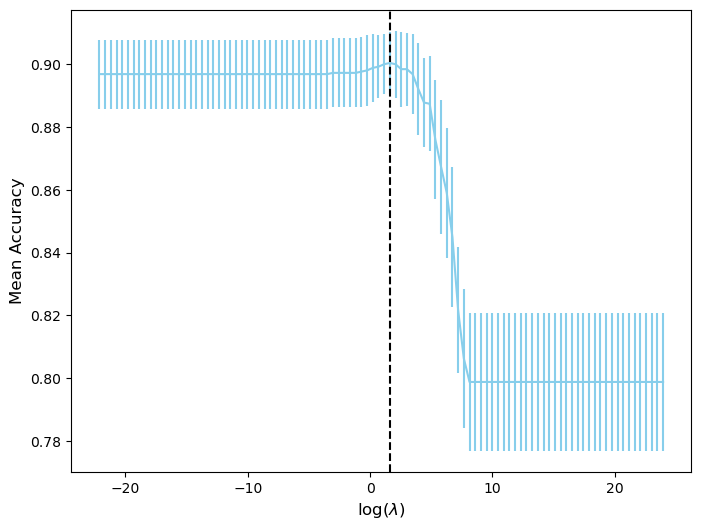

In [20]:
results_ridge = grid_search_logistic_ridge.cv_results_
mean_scores_ridge = results_ridge['mean_test_score']
std_scores_ridge = results_ridge['std_test_score']
param_C_ridge = [params['logisticregression__C'] for params in results_ridge['params']]
param_C_log_ridge = np.log(param_C_ridge)

fig, ax = plt.subplots(figsize=(8, 6))
ax.errorbar(-param_C_log_ridge, mean_scores_ridge, 
            yerr=std_scores_ridge, color='skyblue')
ax.axvline(-np.log(best_alpha_ridge), c='k', ls='--')
ax.set_xlabel('$\log(\lambda)$', fontsize=12)
ax.set_ylabel('Mean Accuracy', fontsize=12)
plt.show()

In [21]:
pipe_logistic_ridge_refit = grid_search_logistic_ridge.best_estimator_
pipe_logistic_ridge_refit.fit(X_train, y_train)

y_pred = pipe_logistic_ridge_refit.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
error_rate = 1 - accuracy
misclassification_error_parametric.append(error_rate)

print(f"Misclassification Error Rate: {error_rate:.4f}")

Misclassification Error Rate: 0.1195


#### Lasso

In [22]:
K = 5
kfold = skm.KFold(K, random_state=0, shuffle=True)

pipe_logistic_lasso = make_pipeline(StandardScaler(),
                                    LogisticRegression(solver='saga', 
                                                       max_iter=500))

lambdas = 10**np.linspace(10, -10, 100) / y_train.std()

param_grid_lasso = {'logisticregression__penalty': ['l1'],
                    'logisticregression__C': 1 / lambdas,
}

grid_search_logistic_lasso = GridSearchCV(pipe_logistic_lasso,
                                          param_grid_lasso,
                                          cv=kfold,
                                          scoring='accuracy')

grid_search_logistic_lasso.fit(X_train, y_train)

best_alpha_lasso = list(grid_search_logistic_lasso.best_params_.values())[0]
print(f"alpha = {best_alpha_lasso}")

alpha = 0.8056261745439867


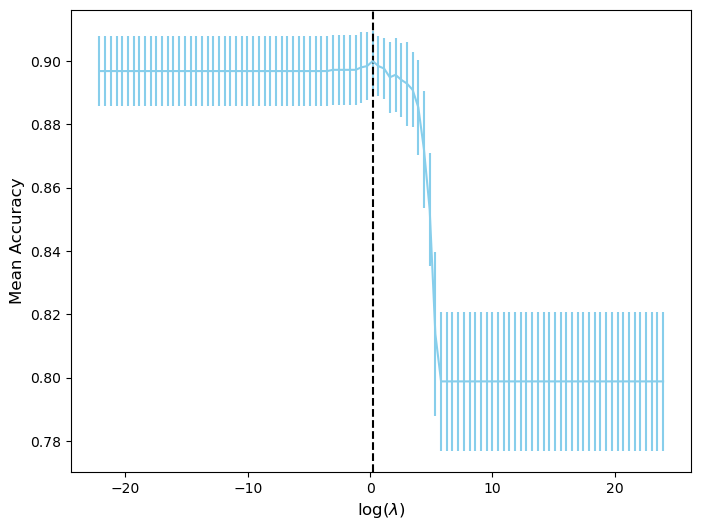

In [23]:
results_lasso = grid_search_logistic_lasso.cv_results_
mean_scores_lasso = results_lasso['mean_test_score']
std_scores_lasso = results_lasso['std_test_score']
param_C_lasso = [params['logisticregression__C'] for params in results_lasso['params']]
param_C_log_lasso = np.log(param_C_lasso)

fig, ax = plt.subplots(figsize=(8, 6))
ax.errorbar(-param_C_log_lasso, mean_scores_lasso, 
            yerr=std_scores_lasso, color='skyblue')
ax.axvline(-np.log(best_alpha_lasso), c='k', ls='--')
ax.set_xlabel('$\log(\lambda)$', fontsize=12)
ax.set_ylabel('Mean Accuracy', fontsize=12)
plt.show()

In [24]:
pipe_logistic_lasso_refit = grid_search_logistic_lasso.best_estimator_
pipe_logistic_lasso_refit.fit(X_train, y_train)

y_pred = pipe_logistic_lasso_refit.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
error_rate = 1 - accuracy
misclassification_error_parametric.append(error_rate)

print(f"Misclassification Error Rate: {error_rate:.4f}")

Misclassification Error Rate: 0.1242


#### PCA

Number of Principal Components = 1, Misclassification Error Rate = 0.1950
Number of Principal Components = 2, Misclassification Error Rate = 0.1572
Number of Principal Components = 3, Misclassification Error Rate = 0.1447
Number of Principal Components = 4, Misclassification Error Rate = 0.1211
Number of Principal Components = 5, Misclassification Error Rate = 0.1242
Number of Principal Components = 6, Misclassification Error Rate = 0.1195
Number of Principal Components = 7, Misclassification Error Rate = 0.1258
Number of Principal Components = 8, Misclassification Error Rate = 0.1226
Number of Principal Components = 9, Misclassification Error Rate = 0.1226
Number of Principal Components = 10, Misclassification Error Rate = 0.1242
Number of Principal Components = 11, Misclassification Error Rate = 0.1242


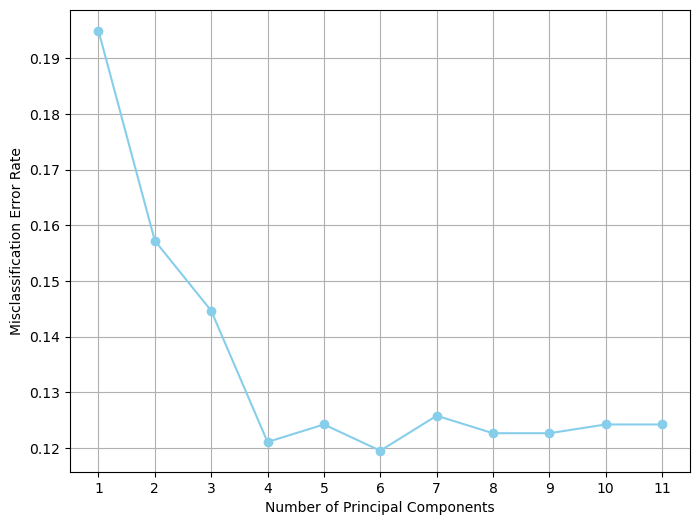


Best Number of Principal Components: 6
Lowest Misclassification Error Rate: 0.1195


In [25]:
best_n_components = 0
best_error_rate = 1
error_rates = []

for n_components in range(1, 12):
    pipe = Pipeline([
        ('scaler', StandardScaler(with_mean=True, with_std=True)),
        ('pca', PCA(n_components=n_components)),
        ('lgr', LogisticRegression())
    ])
    pipe.fit(X_train, y_train)
    
    y_pred = pipe.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    error_rate = 1 - accuracy
    error_rates.append(error_rate)
    print(f"Number of Principal Components = {n_components}, "
          f"Misclassification Error Rate = {error_rate:.4f}")
    
    if(error_rate < best_error_rate):
        best_error_rate = error_rate
        best_n_components = n_components
        
misclassification_error_parametric.append(best_error_rate)

plt.figure(figsize=(8, 6))
plt.plot(range(1, 12), error_rates, marker='o', linestyle='-', color='skyblue')
plt.xlabel('Number of Principal Components')
plt.ylabel('Misclassification Error Rate')
plt.grid(True)
plt.xticks(range(1, 12))
plt.show()

print(f"\nBest Number of Principal Components: {best_n_components}")
print(f"Lowest Misclassification Error Rate: {best_error_rate:.4f}")

#### PLS

Number of Principal Components = 1, Misclassification Error Rate = 0.1447
Number of Principal Components = 2, Misclassification Error Rate = 0.1226
Number of Principal Components = 3, Misclassification Error Rate = 0.1368
Number of Principal Components = 4, Misclassification Error Rate = 0.1305
Number of Principal Components = 5, Misclassification Error Rate = 0.1305
Number of Principal Components = 6, Misclassification Error Rate = 0.1242
Number of Principal Components = 7, Misclassification Error Rate = 0.1258
Number of Principal Components = 8, Misclassification Error Rate = 0.1242
Number of Principal Components = 9, Misclassification Error Rate = 0.1242
Number of Principal Components = 10, Misclassification Error Rate = 0.1242
Number of Principal Components = 11, Misclassification Error Rate = 0.1242


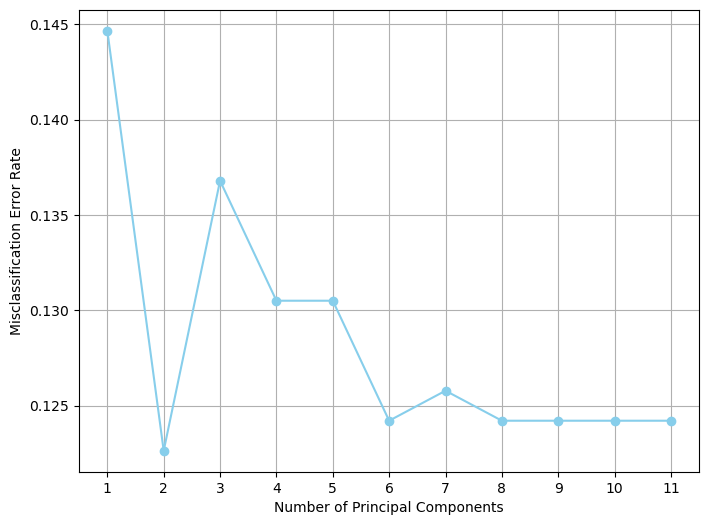


Best Number of Principal Components: 2
Lowest Misclassification Error Rate: 0.1226


In [26]:
best_n_components = 0
best_error_rate = 1
error_rates = []

for n_components in range(1, 12):
    pipe = Pipeline([
        ('scaler', StandardScaler(with_mean=True, with_std=True)),
        ('pls', PLSRegression(n_components=n_components, scale=True))
    ])
    pipe.fit(X_train, y_train)
    
    y_pred = pipe.predict(X_test)
    y_pred_binary = (y_pred >= 0.5).astype(int)
    
    accuracy = accuracy_score(y_test, y_pred_binary)
    error_rate = 1 - accuracy
    error_rates.append(error_rate)
    print(f"Number of Principal Components = {n_components}, "
          f"Misclassification Error Rate = {error_rate:.4f}")
    
    if(error_rate < best_error_rate):
        best_error_rate = error_rate
        best_n_components = n_components

misclassification_error_parametric.append(best_error_rate)

plt.figure(figsize=(8, 6))
plt.plot(range(1, 12), error_rates, marker='o', linestyle='-', color='skyblue')
plt.xlabel('Number of Principal Components')
plt.ylabel('Misclassification Error Rate')
plt.grid(True)
plt.xticks(range(1, 12))
plt.show()


print(f"\nBest Number of Principal Components: {best_n_components}")
print(f"Lowest Misclassification Error Rate: {best_error_rate:.4f}")

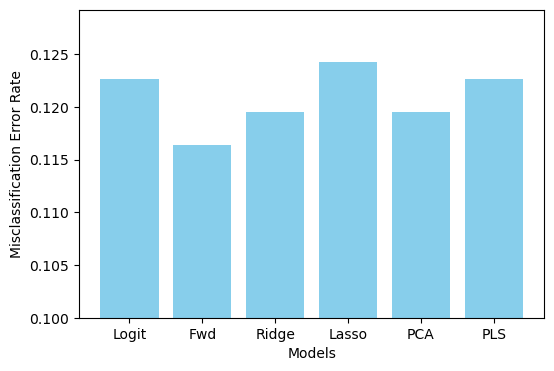

In [27]:
plt.figure(figsize=(6, 4))
plt.bar(['Logit', 'Fwd', 'Ridge', 'Lasso', 'PCA', 'PLS'],
        misclassification_error_parametric, color=['skyblue'])
plt.ylim(0.1, max(misclassification_error_parametric) + 0.005)
plt.xlabel('Models')
plt.ylabel('Misclassification Error Rate')
plt.show()

## Nonparametric Model

#### KNN

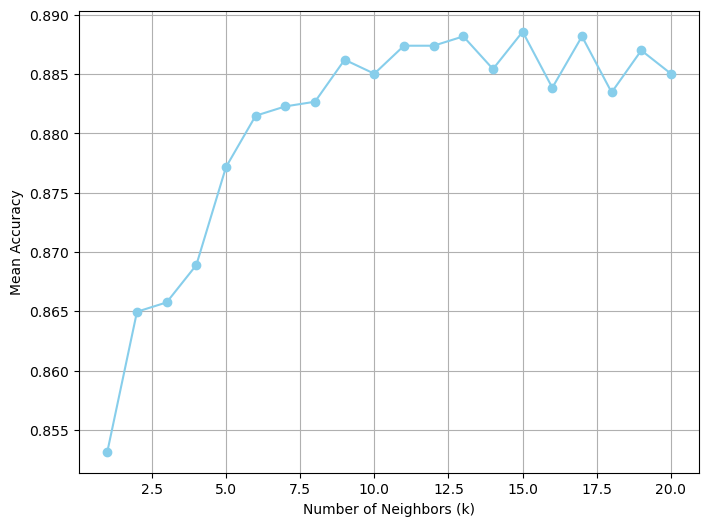

Optimal number of neighbors (k): 15


In [28]:
misclassification_error_nonparametric = []

k_range = range(1, 21)
mean_accuracy = []

scaler = StandardScaler()
knn = KNeighborsClassifier()

pipe = Pipeline(steps=[('scaler', scaler), ('knn', knn)])

for k in k_range:
    pipe.set_params(knn__n_neighbors=k)
    scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='accuracy')
    mean_accuracy.append(np.mean(scores))

plt.figure(figsize=(8, 6))
plt.plot(k_range, mean_accuracy, marker='o', color='skyblue')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean Accuracy')
plt.grid(True)
plt.show()

optimal_k = k_range[np.argmax(mean_accuracy)]
print(f'Optimal number of neighbors (k): {optimal_k}')

In [29]:
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
error_rate = 1 - accuracy
misclassification_error_nonparametric.append(error_rate)

print(f"Misclassification Error Rate: {error_rate:.4f}")

Misclassification Error Rate: 0.1164


#### Classification Tree

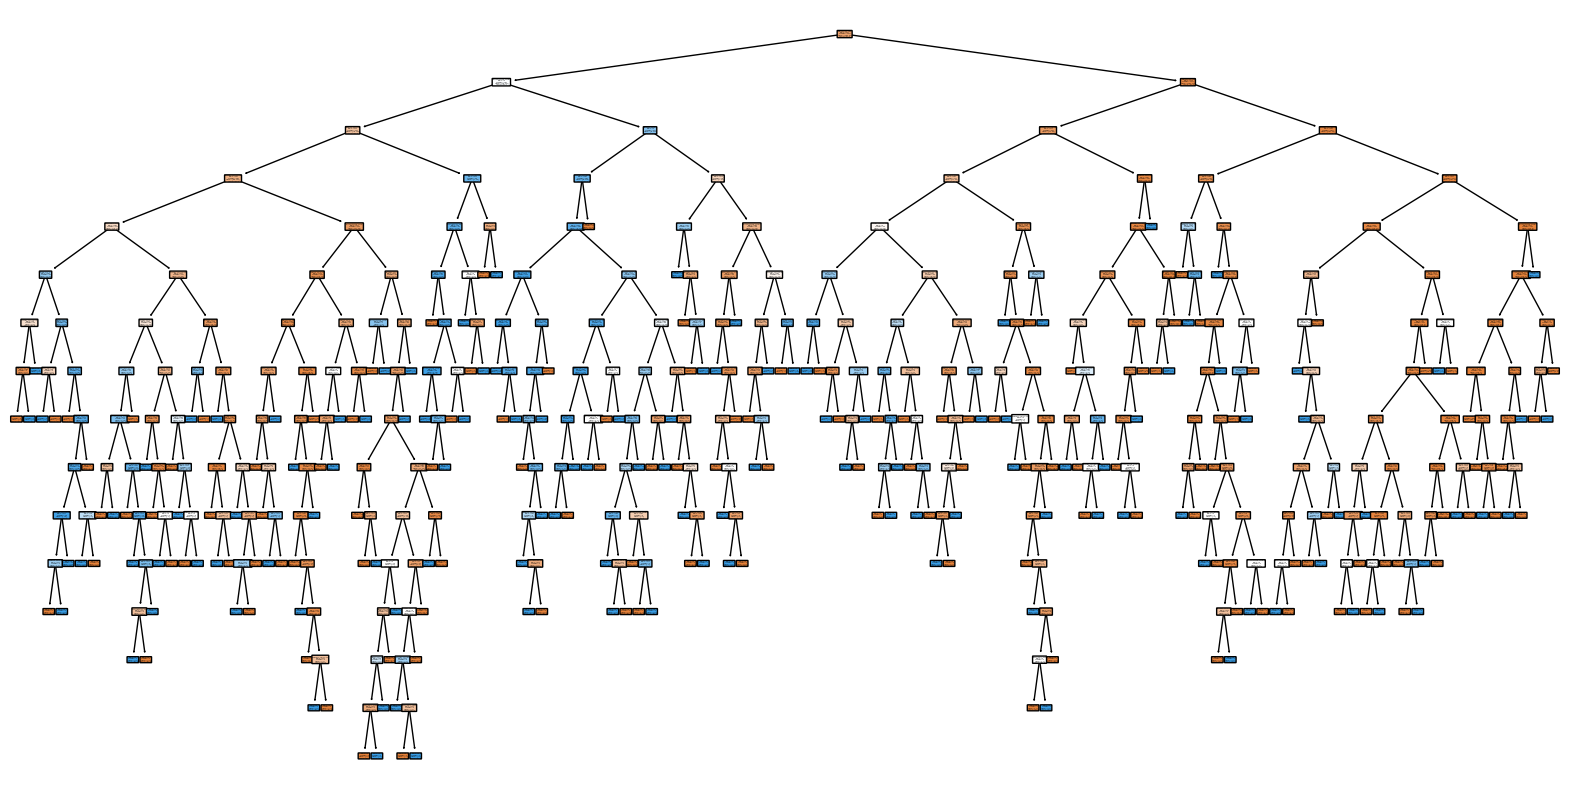

In [30]:
class_tree = DecisionTreeClassifier(random_state=0)
class_tree.fit(X_train, y_train)

plt.figure(figsize=(20, 10))
plot_tree(class_tree, feature_names=X_train.columns, 
          class_names=['Class 0', 'Class 1'], filled=True, rounded=True)
plt.show()

In [31]:
y_pred = class_tree.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
error_rate = 1 - accuracy

print(f"Misclassification Error Rate: {error_rate:.4f}")

Misclassification Error Rate: 0.1572


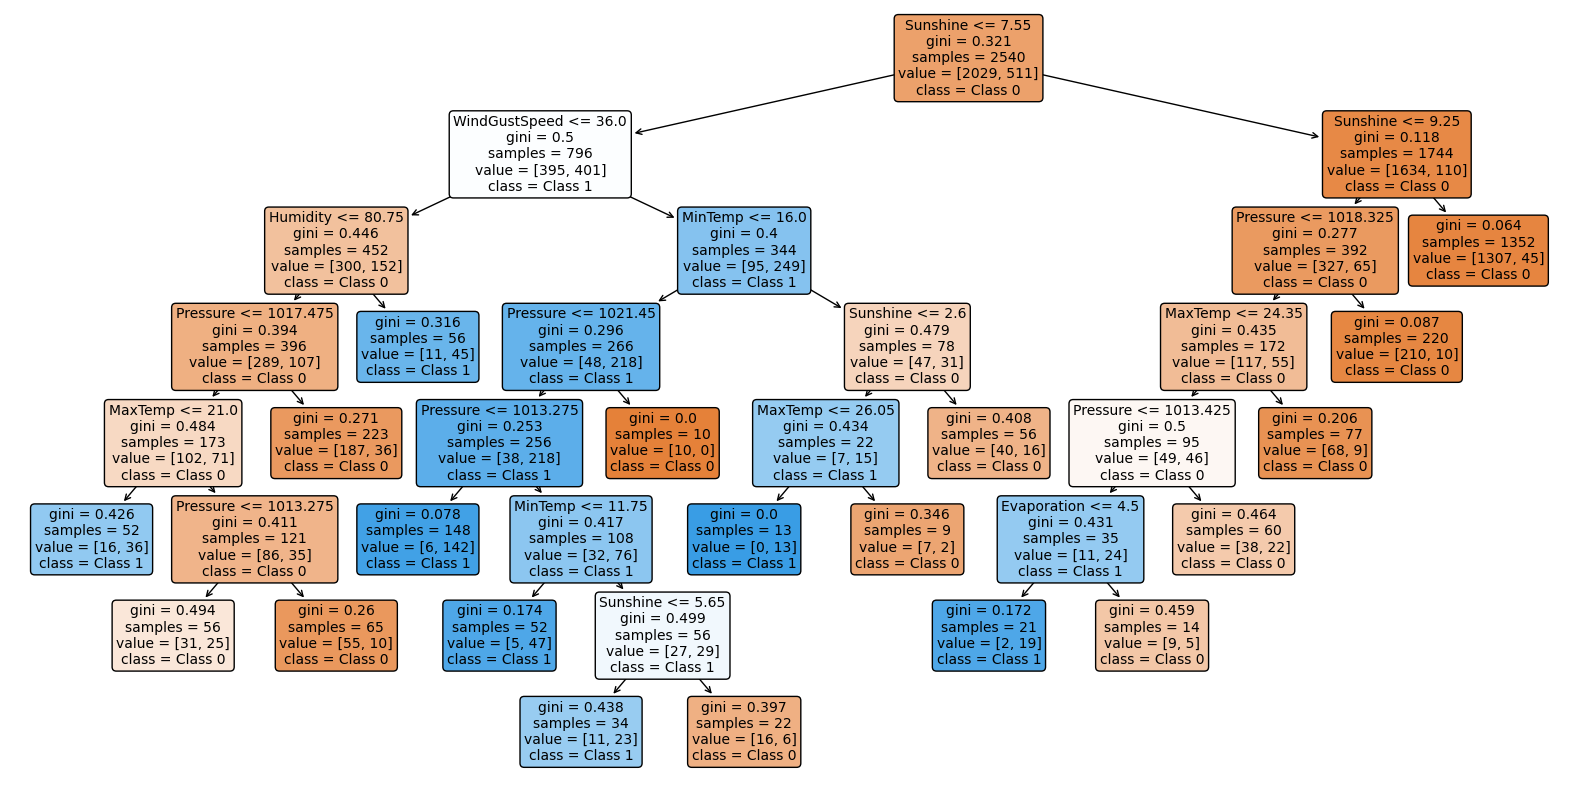

In [32]:
K=5
kfold = skm.KFold(K, random_state=0, shuffle=True)
ccp_path = class_tree.cost_complexity_pruning_path(X_train, y_train)

grid = skm.GridSearchCV(class_tree, 
                        {'ccp_alpha': ccp_path.ccp_alphas},
                        refit=True,
                        cv=kfold,
                        scoring='accuracy') 
grid.fit(X_train, y_train)
best_estimator_class = grid.best_estimator_

plt.figure(figsize=(20, 10))
plot_tree(best_estimator_class, feature_names=X_train.columns, 
          class_names=['Class 0', 'Class 1'], filled=True,
          rounded=True, fontsize=10)
plt.show()

In [33]:
y_pred = best_estimator_class.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
error_rate = 1 - accuracy
misclassification_error_nonparametric.append(error_rate)

print(f"Misclassification Error Rate: {error_rate:.4f}")

Misclassification Error Rate: 0.1211


#### Random Forest

In [34]:
bag = RandomForestClassifier(max_features=X_train.shape[1], random_state=0)
bag.fit(X_train, y_train)
feature_imp = pd.DataFrame({'importance': bag.feature_importances_}, index=X.columns)
feature_imp_df = feature_imp.sort_values(by='importance', ascending=False)
print(feature_imp_df, "\n")

y_pred = bag.predict(X_test)
y_pred_binary = (y_pred >= 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred_binary)
error_rate = 1 - accuracy

print(f"Misclassification Error Rate: {error_rate:.4f}")

               importance
Sunshine         0.328334
Pressure         0.158671
WindGustSpeed    0.102147
Humidity         0.096113
MaxTemp          0.090907
MinTemp          0.084990
Evaporation      0.049373
Month            0.030871
Cloud            0.029571
Rainfall         0.026848
RainToday_Yes    0.002175 

Misclassification Error Rate: 0.1226


In [35]:
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_features': range(1, len(X_train.columns) + 1)
}

rf = RandomForestClassifier(random_state=0)

grid = GridSearchCV(estimator=rf, 
                           param_grid=param_grid, 
                           cv=5, 
                           scoring='accuracy')
grid.fit(X_train, y_train)

best_params_rf = grid.best_params_
print("Best parameters:", best_params_rf)

Best parameters: {'max_features': 4, 'n_estimators': 200}


In [36]:
rf = RandomForestClassifier(n_estimators=200, max_features=4, random_state=0)
rf.fit(X_train, y_train) 
feature_imp = pd.DataFrame({'importance':rf.feature_importances_}, 
                               index=X_train.columns)
feature_imp_df = feature_imp.sort_values(by='importance', ascending=False)
print(feature_imp_df, "\n")

y_pred = rf.predict(X_test)
y_pred_binary = (y_pred >= 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred_binary)
error_rate = 1 - accuracy
misclassification_error_nonparametric.append(error_rate)

print(f"Misclassification Error Rate: {error_rate:.4f}")

               importance
Sunshine         0.204480
Pressure         0.151665
Humidity         0.150528
WindGustSpeed    0.099423
MaxTemp          0.078886
MinTemp          0.077145
Cloud            0.075138
Evaporation      0.059288
Rainfall         0.056370
Month            0.036474
RainToday_Yes    0.010604 

Misclassification Error Rate: 0.1132


#### Gradient Boosting

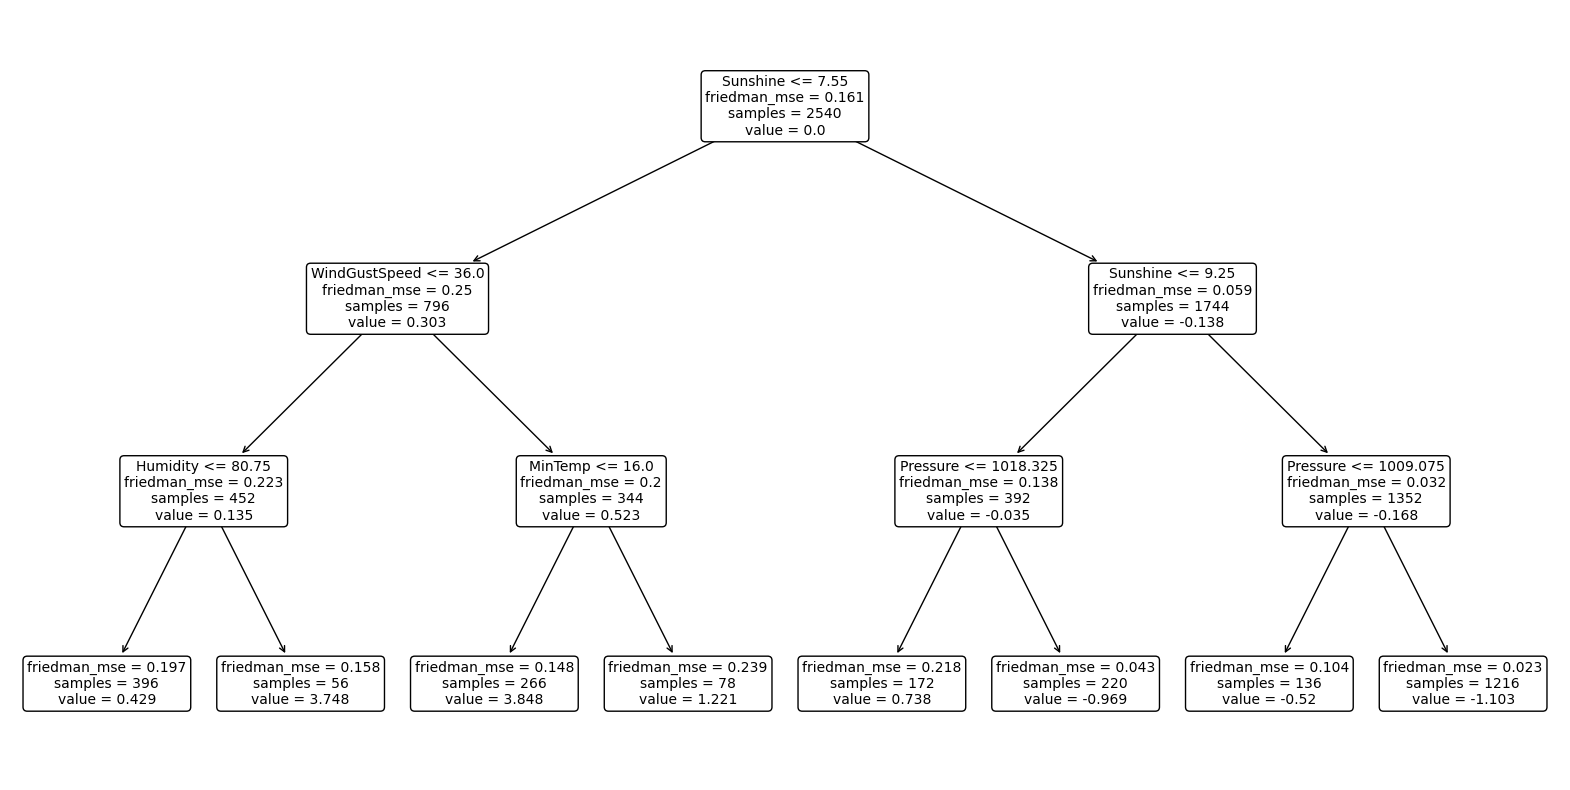

In [37]:
boost = GradientBoostingClassifier(n_estimators=5000,
                                   learning_rate=0.02,
                                   max_depth=3,
                                   random_state=0)
boost.fit(X_train, y_train)

plt.figure(figsize=(20, 10))
plot_tree(boost.estimators_[0, 0], feature_names=X_train.columns, 
          rounded=True, fontsize=10)
plt.show()

In [38]:
y_pred = boost.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
error_rate = 1 - accuracy

print(f"Misclassification Error Rate: {error_rate:.4f}")

Misclassification Error Rate: 0.1164


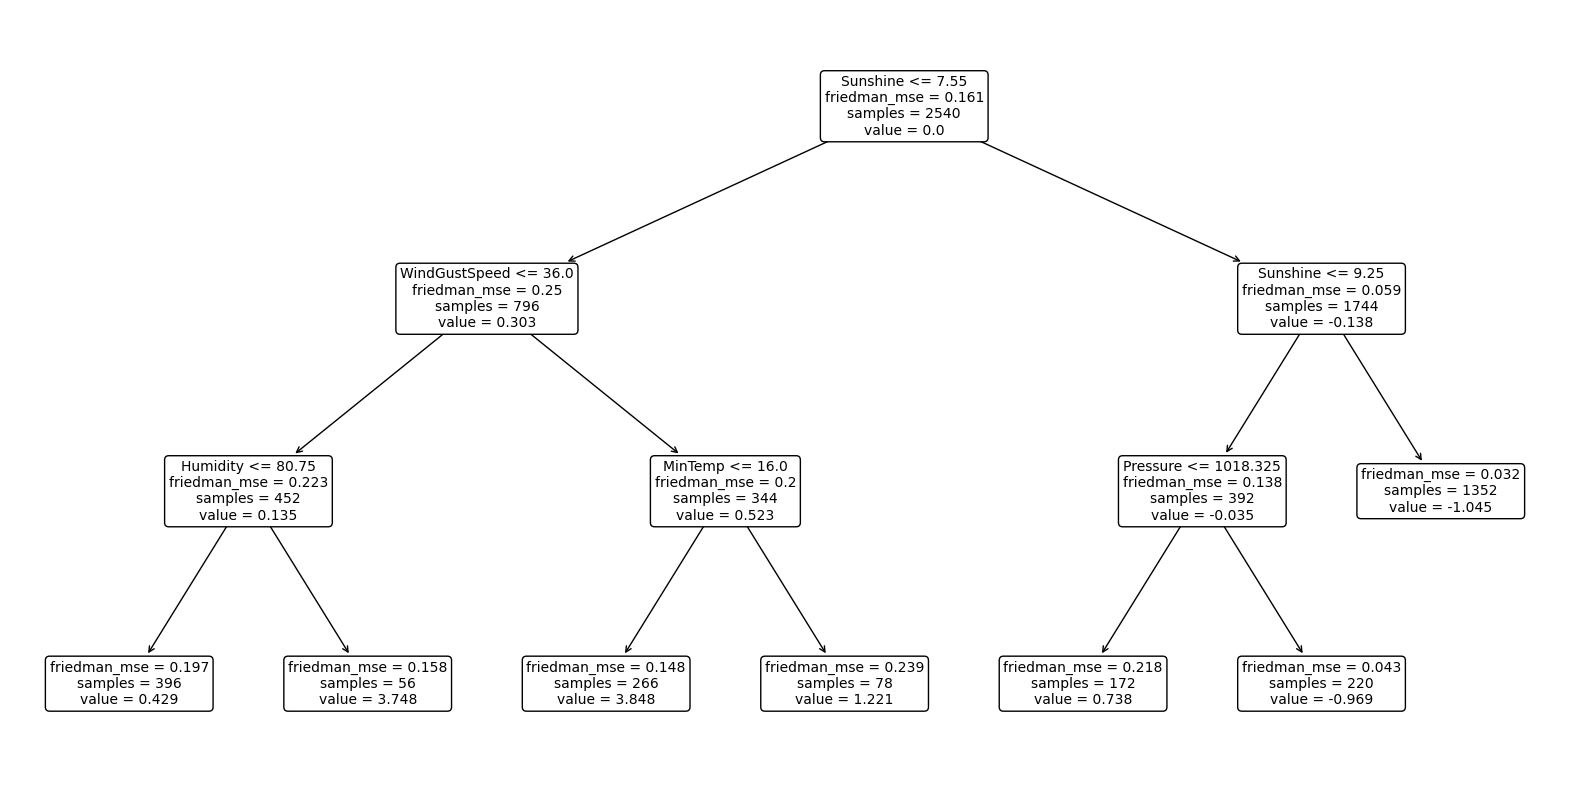

In [39]:
K = 5
kfold = skm.KFold(K, random_state=0, shuffle=True)
tree_estimator = boost.estimators_[0, 0]
ccp_path = tree_estimator.cost_complexity_pruning_path(X_train, y_train)

grid = GridSearchCV(boost,
                    {'ccp_alpha': ccp_path.ccp_alphas},
                    refit=True,
                    cv=kfold,
                    scoring='accuracy')
grid.fit(X_train, y_train)
best_estimator_boost = grid.best_estimator_

plt.figure(figsize=(20, 10))
plot_tree(best_estimator_boost.estimators_[0, 0], feature_names=X_train.columns, 
          rounded=True, fontsize=10)
plt.show()

In [40]:
y_pred = best_estimator_boost.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
error_rate = 1 - accuracy
misclassification_error_nonparametric.append(error_rate)

print(f"Misclassification Error Rate: {error_rate:.4f}")

Misclassification Error Rate: 0.1085


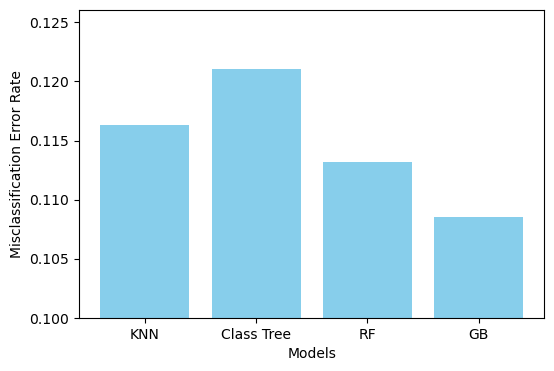

In [42]:
plt.figure(figsize=(6, 4))
plt.bar(['KNN', 'Class Tree', 'RF', 'GB'],
        misclassification_error_nonparametric, color=['skyblue'])
plt.ylim(0.1, max(misclassification_error_nonparametric) + 0.005)
plt.xlabel('Models')
plt.ylabel('Misclassification Error Rate')
plt.show()